<a href="https://colab.research.google.com/github/kwasicode/Artificial-Intelligence/blob/main/vehicle_gans_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import zipfile
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input, Conv2D, UpSampling2D
from tensorflow.keras.models import Sequential, Model

In [ ]:
# Load and Extract Dataset
zip_path = '/content/sports_car.zip'
extract_path = '/content/sports_car'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
# Preprocess the Dataset
def preprocess_images(image_path, target_size=(64, 64)):
    img = Image.open(image_path)
    img = img.resize(target_size, Image.ANTIALIAS)
    img = np.array(img) / 127.5 - 1.0
    return img

data = []
for root, dirs, files in os.walk(extract_path):
    for file in files:
        if file.endswith(('.jpg', '.png', '.jpeg')):
            image_path = os.path.join(root, file)
            data.append(preprocess_images(image_path))
data = np.array(data)

<ipython-input-47-18457881907c>:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(target_size, Image.ANTIALIAS)


In [ ]:
# Build the Generator and Discriminator
def build_generator(latent_dim):
    generator = Sequential()
    generator.add(Dense(128 * 16 * 16, input_dim=latent_dim))
    generator.add(LeakyReLU(0.2))
    generator.add(Reshape((16, 16, 128)))
    generator.add(UpSampling2D())
    generator.add(Conv2D(128, kernel_size=3, padding='same'))
    generator.add(BatchNormalization(momentum=0.8))
    generator.add(LeakyReLU(0.2))
    generator.add(UpSampling2D())
    generator.add(Conv2D(64, kernel_size=3, padding='same'))
    generator.add(BatchNormalization(momentum=0.8))
    generator.add(LeakyReLU(0.2))
    generator.add(Conv2D(3, kernel_size=3, padding='same', activation='tanh'))
    return generator

def build_discriminator(input_shape):
    discriminator = Sequential()
    discriminator.add(Conv2D(32, kernel_size=3, strides=2, input_shape=input_shape, padding='same'))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))
    discriminator.add(BatchNormalization(momentum=0.8))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    discriminator.add(BatchNormalization(momentum=0.8))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation='sigmoid'))
    return discriminator

In [ ]:
# Build the GAN Model
def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=(latent_dim,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(gan_input, gan_output)
    return gan

In [ ]:
# Compile the Models
latent_dim = 100
generator = build_generator(latent_dim)
discriminator = build_discriminator((64, 64, 3))
gan = build_gan(generator, discriminator)

generator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
gan.compile(loss='binary_crossentropy', optimizer='adam')

In [ ]:
# Train the GAN
def train_gan(generator, discriminator, gan, data, epochs=100, batch_size=64):
    batch_count = data.shape[0] // batch_size

    for epoch in range(epochs):
        for _ in range(batch_count):
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            generated_images = generator.predict(noise)
            image_batch = data[np.random.randint(0, data.shape[0], size=batch_size)]

            X = np.concatenate([image_batch, generated_images])
            y_dis = np.zeros(2 * batch_size)
            y_dis[:batch_size] = 0.9

            d_loss = discriminator.train_on_batch(X, y_dis)

            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            y_gen = np.ones(batch_size)
            g_loss = gan.train_on_batch(noise, y_gen)

        print(f"Epoch {epoch} | Discriminator Loss: {d_loss} | Generator Loss: {g_loss}")



In [ ]:
# Generate and Visualize Synthetic Images
# Generate Synthetic Vehicle Shapes
def generate_images(generator, latent_dim, num_images=10):
    noise = np.random.normal(0, 1, size=[num_images, latent_dim])
    generated_images = generator.predict(noise)
    return generated_images

num_generated_images = 10
train_gan(generator, discriminator, gan, data, epochs=50, batch_size=64)
synthetic_images = generate_images(generator, latent_dim, num_images=num_generated_images)

2/2 [==============================] - 1s 545ms/step
Epoch 0 | Discriminator Loss: 3.2364449501037598 | Generator Loss: 0.0031020729802548885
2/2 [==============================] - 1s 560ms/step
Epoch 1 | Discriminator Loss: 3.241562843322754 | Generator Loss: 0.0029944833368062973
2/2 [==============================] - 1s 559ms/step
Epoch 2 | Discriminator Loss: 3.254511594772339 | Generator Loss: 0.0029514762572944164
2/2 [==============================] - 1s 555ms/step
Epoch 3 | Discriminator Loss: 3.267878532409668 | Generator Loss: 0.0029317692387849092
2/2 [==============================] - 1s 578ms/step
Epoch 4 | Discriminator Loss: 3.262998104095459 | Generator Loss: 0.002897808328270912
2/2 [==============================] - 1s 572ms/step
Epoch 5 | Discriminator Loss: 3.2721760272979736 | Generator Loss: 0.00288928160443902
2/2 [==============================] - 1s 570ms/step
Epoch 6 | Discriminator Loss: 3.2768542766571045 | Generator Loss: 0.002915794961154461
2/2 [=========

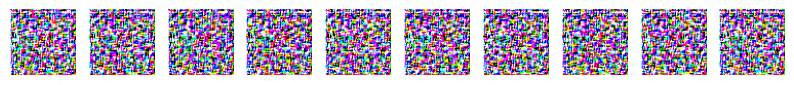

In [61]:
# Visualize Synthetic Images
visualize_images(synthetic_images)